In [3]:
import os
import cv2
import math
import json
import glob
import random
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from collections import namedtuple
from matplotlib import pyplot as plt

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


# modified 'license plate' from -1 -> 34 and 19
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

CLASS_MAP = {val.id:val.name for val in labels}
COLOR_MAP = {val.id:val.color for val in labels}

In [ ]:
# get classes list from image path        
def get_classes_names(path, class_names):
    gray = cv2.imread(path, 0)
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret_list = []
    for i in np.unique(gray): ret_list.append(class_names[i])
    return ret_list


def get_class_dist_df(filename):
    with open(filename, 'r') as f:
        data = f.readlines()

    dict_data = [json.loads(val) for val in data]
    df = pd.DataFrame(dict_data)
    
    # dict of classes. 1:contain class, 0:NO class
    classes = {val:[] for val in VOC_CLASSES}
    image_ids = []
    
    for index, row in df.iterrows():
        label_path = row['fpath_segm']
        img_id = label_path.split('/')[-1].split('.')[0]

        image_ids.append(img_id)
        tmp_classes = get_classes_names(label_path, VOC_CLASSES)

        for k, v in classes.items():
            if k in tmp_classes:
                classes[k].append(1)
            else:
                classes[k].append(0)

    df['id'] = image_ids

    for k, v in classes.items():
        df[k] = classes[k]
        
    return df

In [ ]:
def color_image(path, colors):
    img = cv2.imread(path)
    for i, v in colors.items():
        img[:,:,0][np.where(img[:,:,0] == i)] = v[0]
        img[:,:,1][np.where(img[:,:,1] == i)] = v[1]
        img[:,:,2][np.where(img[:,:,2] == i)] = v[2]
    return img

def seg_infor(seg_path, class_names):
    seg = cv2.imread(seg_path, 0)
    h = seg.shape[0]
    w = seg.shape[1]
    # seg_classes = [class_names[i] for i in np.unique(seg)]
    seg_classes = []
    for i in np.unique(seg):
        # in case, I just want eval classes
        try: 
            seg_classes.append(class_names[i])
        except:
            pass
    return seg_classes, w, h

# assume img are in "leftImg8bit/"
def path_segToimg(seg_path):
    img_path = seg_path.replace('gtFine', 'leftImg8bit', 1)
    img_path = img_path.replace('gtFine_labelIds', 'leftImg8bit')
    return img_path

# assume seg are in "gtFine/"
def path_imgToseg(img_path):
    seg_path = img_path.replace("leftImg8bit", "gtFine", 1)
    seg_path = seg_path.replace("leftImg8bit", "gtFine_labelIds")
    return seg_path

'''
- file_path
    - city a 
        - img1
        - img2
    - city b
        - img1
        - img2
    ...
''' 

def get_all_imgs(file_path):
    # file_path = "/usb/datasets/cityscapes_dataset/leftImg8bit/train/"
    cities_train = os.listdir(file_path)
    all_imgs = []
    for c in cities_train:
        imgs = ["{}{}/{}".format(file_path, c, i) for i in os.listdir("{}{}".format(file_path, c))]
        all_imgs.extend(imgs)
    return all_imgs

def df_gen(train_imgs_path, CLASS_MAP):
    train_segs_path = []
    for img in train_imgs_path:
        seg_path = path_imgToseg(img)
        train_segs_path.append(seg_path)

    cities = []
    widths = []
    heights = []
    class_list_dict = {v:[] for k, v in CLASS_MAP.items()}

    for seg in tqdm(train_segs_path):
        seg_classes, w, h = seg_infor(seg, CLASS_MAP)
        city = seg.split('/')[-2]

        cities.append(city)
        widths.append(w)
        heights.append(h)

        for k, v in CLASS_MAP.items():
            if v in seg_classes:
                class_list_dict[v].append(1)
            else:
                class_list_dict[v].append(0)


    df = pd.DataFrame()

    df['image'] = train_imgs_path
    df['segmentation'] = train_segs_path
    df['city'] = cities
    df['width'] = widths
    df['height'] = heights

    for k, v in class_list_dict.items():
        df[k] = class_list_dict[k]
    return df

In [ ]:
'''
imgs_path = get_all_imgs("/usb/datasets/cityscapes_dataset/leftImg8bit/train/")
df = df_gen(imgs_path, CLASS_MAP)
print("train: {}".format(len(df)))
df.to_csv("../data/cityscape_csv/train.csv")

imgs_path = get_all_imgs("/usb/datasets/cityscapes_dataset/leftImg8bit/val/")
df = df_gen(imgs_path, CLASS_MAP)
print("val: {}".format(len(df)))
df.to_csv("../data/cityscape_csv/val.csv")

imgs_path = get_all_imgs("/usb/datasets/cityscapes_dataset/leftImg8bit/test/")
df = df_gen(imgs_path, CLASS_MAP)
print("test: {}".format(len(df)))
df.to_csv("../data/cityscape_csv/test.csv")
'''
print()

## EVAL Cityscape Classes Only 

In [ ]:
EVAL_CLASS_MAP = {}
EVAL_COLOR_MAP = {}

for val in labels:
    if not val.ignoreInEval:
        EVAL_CLASS_MAP[val.trainId] = val.name
        EVAL_COLOR_MAP[val.trainId] = val.color

In [ ]:
'''
imgs_path = get_all_imgs("/usb/datasets/cityscapes_dataset/leftImg8bit/train/")
df = df_gen(imgs_path, EVAL_CLASS_MAP)
print("train: {}".format(len(df)))
df.to_csv("../data/cityscape_csv/eval_train.csv")

imgs_path = get_all_imgs("/usb/datasets/cityscapes_dataset/leftImg8bit/val/")
df = df_gen(imgs_path, EVAL_CLASS_MAP)
print("val: {}".format(len(df)))
df.to_csv("../data/cityscape_csv/eval_val.csv")

imgs_path = get_all_imgs("/usb/datasets/cityscapes_dataset/leftImg8bit/test/")
df = df_gen(imgs_path, EVAL_CLASS_MAP)
print("test: {}".format(len(df)))
df.to_csv("../data/cityscape_csv/eval_test.csv")
'''
print()

# Calculating IoU

In [2]:
def vis_pair(img1, img2, label1, label2):
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)
    label1 = cv2.imread(label1)
    label2 = cv2.imread(label2)
    
    tmp_label2 = cv2.resize(label2, (int(label1.shape[1]), int(label1.shape[0])))
    
    label1[np.where(label1 == 0)] = 255 # to exclude the bg from intersection
    
    intersection = np.where(label1[:,:,0] == tmp_label2[:,:,0])[0].shape[0]
    union = np.where(label1[:,:,0] != 255 )[0].shape[0] + np.where(tmp_label2[:,:,0] != 0 )[0].shape[0] - intersection

    return intersection/union


def class_pair_iou(df, CLASS_LIST):
    output = ""
    for i, c in enumerate(CLASS_LIST):
        if c != 'unlabeled':
            sub_data = df[df[c]==1]
            count = 0
            pbar = tqdm(total=sum(1 for ignore in itertools.combinations(sub_data['image'], 2)))
            for pair in itertools.combinations(sub_data['image'], 2):
                pbar.set_description("{}".format(c))
                pbar.update(1)
                row1 = df[df['image']==pair[0]]
                row2 = df[df['image']==pair[1]]
                imgs = [row1['image'].values[0],row2['image'].values[0]]
                segms = [row1['segmentation'].values[0], row2['segmentation'].values[0]]
                w, h =  row1['width'].values[0], row1['height'].values[0]
                iou = vis_pair(imgs[0], imgs[1], segms[0], segms[1])
                new_line = {}
                new_line["fpath_img"], new_line["fpath_segm"], new_line["width"], new_line["height"], new_line['iou'] = \
                        imgs, segms, int(w), int(h), iou
                output += json.dumps(new_line) + "\n"
                
                # test
                break
            pbar.close()
    return output

def save_odgt(file_to_save, output_path, overwrite=False):
    if os.path.exists(file_to_save) and not overwrite:
        print("File exists!")
        return
    elif os.path.exists(file_to_save) and overwrite:
        print("Overwrite file!")
    with open(output_path, 'w') as fp:
        fp.write(file_to_save)
        
def plot_hist_from_odgt(file_path, greater_than=0.5):
    df_pairs = pd.read_json(file_path, lines=True)
    df_pairs[df_pairs['iou'] > greater_than]['iou'].hist()

In [ ]:
df = pd.read_csv("../data/cityscape_csv/train.csv")
CLASS_LIST = list(EVAL_CLASS_MAP.values())

output = class_pair_iou(df, CLASS_LIST)
save_odgt(output, '../data/cityscape_csv/test.odgt')

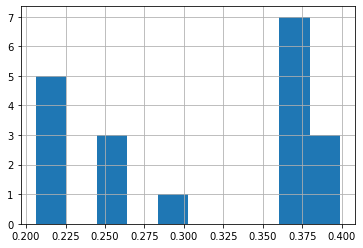

In [4]:
plot_hist_from_odgt('../data/cityscape_csv/eval_train_all_iou.odgt', 0)

In [ ]:
img_path = '/usb/datasets/cityscapes_dataset/leftImg8bit/train/stuttgart/stuttgart_000110_000019_leftImg8bit.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)

img_path = '/usb/datasets/cityscapes_dataset/leftImg8bit/train/stuttgart/stuttgart_000111_000019_leftImg8bit.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [ ]:
colored_seg = color_image(path_imgToseg(img_path), COLOR_MAP)
plt.figure(figsize=(13, 13))
plt.imshow(colored_seg)
plt.show()

## DataFrames Visualization

In [ ]:
df = pd.read_csv('../data/cityscape_csv/eval_train.csv')
df.head(10)